In [1]:
import os, sys

codepath = '/user_data/mmhender/image_stats_gabor/code/'
sys.path.insert(0,codepath)

import numpy as np

import matplotlib.pyplot as plt
from matplotlib import cm

import pandas as pd

from plotting import plot_utils
from model_fitting import initialize_fitting 
from utils import numpy_utils, default_paths
from analyze_features import analyze_feature_decoding


In [8]:
import statsmodels.stats.multitest

In [9]:
statsmodels.stats.multitest

<module 'statsmodels.stats.multitest' from '/home/mmhender/myenv/lib/python3.7/site-packages/statsmodels/stats/multitest.py'>

In [2]:
# Load everything

subject=999; # 999 is our independent set of 10,000 COCO images
feature_type='gabor_solo'
acc, dprime, names = analyze_feature_decoding.load_decoding(feature_type, \
                                                            balanced=True, \
                                                            subject=subject, \
                                                            verbose=True)
n_axes = len(names)

loading from /user_data/mmhender/features/gabor_texture/feature_decoding/S999_gabor_solo_LDA_all_grid5_balanced.npy


In [10]:
analyze_feature_decoding.analyze_decoding_slopes(subject, \
                     feature_type, which_prf_grid=5, \
                     balanced=True, \
                     rndseed=309468, n_iter=10000)

using 1280 pRFs
saving to /user_data/mmhender/features/gabor_texture/feature_decoding/prf_decoding_slopes_balanced.csv


In [11]:
fn2load = os.path.join(default_paths.gabor_texture_feat_path, \
                       'feature_decoding', 'prf_decoding_slopes_balanced.csv')
slopes_df = pd.read_csv(fn2load, index_col=0)
slopes_df.iloc[:,[0,3,4,5,8,9,10,13,14,15,18,19]]

,size slope,size pval,size fdr sig,eccen slope,eccen pval,eccen fdr sig,xpos slope,xpos pval,xpos fdr sig,ypos slope,ypos pval,ypos fdr sig
indoor_outdoor,0.105848,0.0,True,0.045583,0.0,True,0.000687,0.912200,False,-0.009445,0.223733,False
animacy,0.091101,0.0,True,-0.045681,0.0,True,-0.004191,0.565200,False,-0.026601,0.000000,True
real_world_size_binary,0.063966,0.0,True,-0.043257,0.0,True,-0.001722,0.783491,False,-0.016918,0.000600,True


In [12]:
slope_inds = np.array(['slope' in key for key in slopes_df.keys()])
slope_values = np.array(slopes_df)[:,slope_inds]
inter_inds = np.array(['inter' in key for key in slopes_df.keys()])
inter_values = np.array(slopes_df)[:,inter_inds]
sig_inds = np.array(['fdr sig' in key for key in slopes_df.keys()])
mask_fdr = np.array(slopes_df)[:,sig_inds]

In [13]:
mask_fdr

array([[True, True, False, False],
       [True, True, False, True],
       [True, True, False, True]], dtype=object)

#### Organizing info about the pRF parameters

In [14]:
models = initialize_fitting.get_prf_models(which_grid=5)
n_prfs = len(models)

x = models[:,0]*8.4; y = models[:,1]*8.4;
angles = np.round(np.mod(np.arctan2(y,x)*180/np.pi, 360),1)
ecc = np.round(np.sqrt(models[:,0]**2+models[:,1]**2)*8.4, 4)
no_angle = ecc<10**(-2)
angles[no_angle] = np.nan
sizes = np.round(models[:,2]*8.4, 4)

ecc_vals = np.unique(ecc)
size_vals = np.unique(sizes)
n_ecc = len(ecc_vals);
n_angles = len(np.unique(angles))-1
n_sizes = len(size_vals)

pars = [sizes, ecc, x, y]
par_names = ['size', 'eccen', 'xpos', 'ypos']

#### Choosing which pRFs to use for our analysis
Want to exclude the largest few eccentricities where not all sizes/angles are represented.

In [15]:
counts = np.array([np.sum(ecc==ecc_vals[ee]) for ee in range(n_ecc)])
ecc_use = counts==(n_angles*n_sizes)
prfs_use = np.isin(ecc,ecc_vals[ecc_use])

In [16]:
ecc_vals

array([0.    , 0.2366, 0.5399, 0.9286, 1.4268, 2.0653, 2.8837, 3.9326,
       5.2769, 7.    ], dtype=float32)

In [17]:
ecc_use

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False])

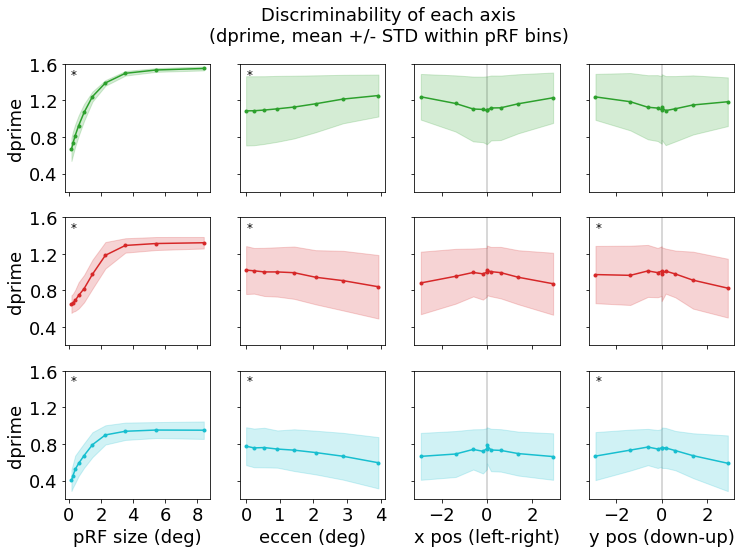

In [19]:
# plot semantic corr coefs as a function of pRF params

plt.figure(figsize=(12,8));
plot_utils.set_all_font_sizes(12)
plt.rcParams['pdf.fonttype']=42

colors = cm.tab10(np.linspace(0,1,10))[[2, 3, 9],:]

# n_bins = 10;
# linear_bins=False
n_bins=10
linear_bins=False

ylims = [0.2, 1.6];
yticks = [0.4, 0.8, 1.2, 1.6]

xticks = [[0,2,4,6,8], [0,1,2,3,4], [-2, 0, 2], [-2, 0, 2]]

starlocs = [[0.3, 1.45], [0.1, 1.45], [-2.8, 1.45], [-2.8, 1.45]]

plot_utils.set_all_font_sizes(18)
pi=0;

for ai in range(n_axes):
    
    name = names[ai]
    vals = dprime[prfs_use,ai]
    
    pi+=1
    plt.subplot(3,4,pi)
    
    x_vals = sizes[prfs_use]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==2:
        plt.xlabel('pRF size (deg)')
        plt.xticks(xticks[0])
    else:
        plt.xticks(xticks[0], labels=[])
    plt.ylabel('dprime')
    plt.ylim(ylims)
    plt.yticks(yticks)
    if mask_fdr[ai,0]:
        plt.gca().annotate('*',
                    xy=starlocs[0],
                    zorder=20,
                    color="k",
                    ha="center",
                    fontsize=12,
                )

    pi+=1
    plt.subplot(3,4,pi)
    
    x_vals = ecc[prfs_use]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True, \
                                                            use_unique=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==2:
        plt.xlabel('eccen (deg)')
        plt.xticks(xticks[1])
    else:
        plt.xticks(xticks[1], labels=[])
    plt.ylim(ylims)
    plt.yticks(yticks,labels=[])
    if mask_fdr[ai,1]:
        plt.gca().annotate('*',
                    xy=starlocs[1],
                    zorder=20,
                    color="k",
                    ha="center",
                    fontsize=12,
                )
    pi+=1
    plt.subplot(3,4,pi)
    
    x_vals = x[prfs_use]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.plot(xbinned, ybinned, '.-', color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==2:
        plt.xlabel('x pos (left-right)')
        plt.xticks(xticks[2])
    else:
        plt.xticks(xticks[2], labels=[])
    # plt.ylabel('dprime')
    plt.ylim(ylims)
    plt.yticks(yticks,labels=[])
    plt.axvline(0, color=[0.8, 0.8, 0.8])
    if mask_fdr[ai,2]:
        plt.gca().annotate('*',
                    xy=starlocs[2],
                    zorder=20,
                    color="k",
                    ha="center",
                    fontsize=12,
                )

    pi+=1
    plt.subplot(3,4,pi)
    
    x_vals = y[prfs_use]

    xbinned, ybinned, ystd = numpy_utils.bin_ydata_by_xdata(x_vals, vals, n_bins=n_bins, \
                                            linear_bins=linear_bins, return_std=True)    
    plt.plot(xbinned, ybinned, '.-',color=colors[ai,:] ,zorder=10)
    plt.fill_between(xbinned, ybinned-ystd, ybinned+ystd,
            alpha=0.2, edgecolor=colors[ai,:], facecolor=colors[ai,:], zorder=10)

    if ai==2:
        plt.xlabel('y pos (down-up)')
        plt.xticks(xticks[3])
    else:
        plt.xticks(xticks[3], labels=[])
    plt.ylim(ylims)
    plt.yticks(yticks,labels=[])
    plt.axvline(0, color=[0.8, 0.8, 0.8])
    if mask_fdr[ai,3]:
        plt.gca().annotate('*',
                    xy=starlocs[3],
                    zorder=20,
                    color="k",
                    ha="center",
                    fontsize=12,
                )
        
    plt.suptitle('Discriminability of each axis\n(dprime, mean +/- STD within pRF bins)')
    
# fn2save = '/user_data/mmhender/imStat/figures/Gabor_decoding_spatialbins.pdf'
# plt.savefig(fn2save)

fn2save = os.path.join(default_paths.fig_path,'Gabor_decoding_spatialbins_sepplots.pdf')
plt.savefig(fn2save)

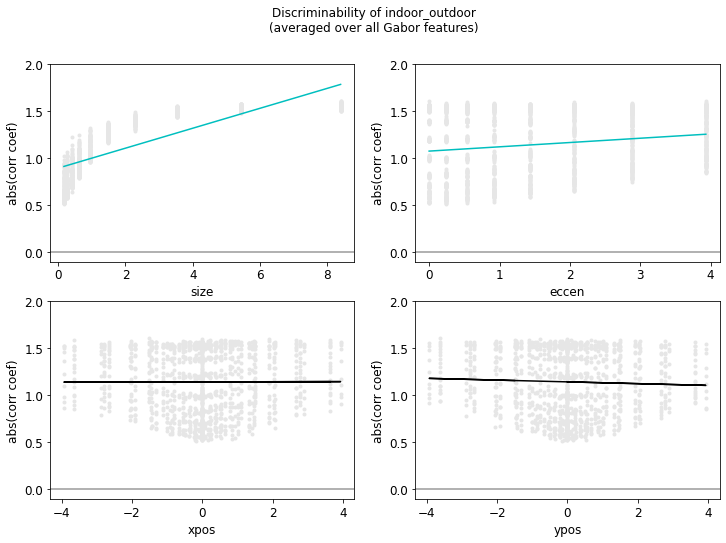

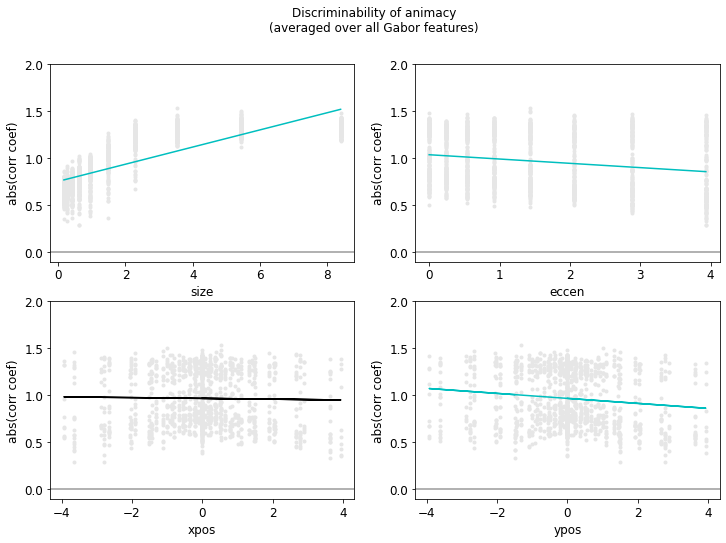

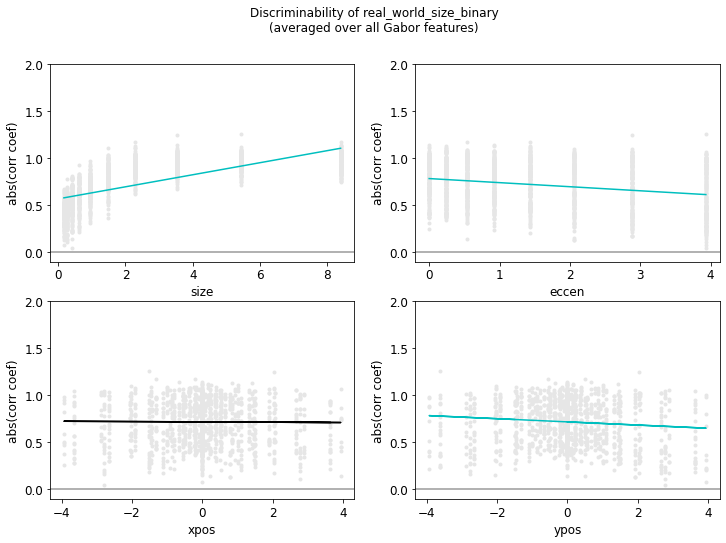

In [18]:
# Plot actual points - significant fits in cyan

plot_utils.set_all_font_sizes(12)

n_axes = len(names)
for ai in range(n_axes):
    
    name = names[ai]
    vals = dprime[prfs_use,ai]

    plt.figure(figsize=(12,8));

    for pi, par in enumerate(pars):
        
        plt.subplot(2,2,pi+1)
        
        x_vals = par[prfs_use];
        yhat = x_vals*slope_values[ai,pi]+inter_values[ai,pi]
    
        if mask_fdr[ai,pi]:
            linecolor='c'
        else:
            linecolor='k'
            
        plt.plot(x_vals, vals,'.',color=[0.9, 0.9, 0.9])
        plt.plot(x_vals, yhat, '-', color=linecolor)

        plt.xlabel('%s'%par_names[pi])
        plt.ylabel('abs(corr coef)')
        plt.ylim([-0.1, 2.0])
        plt.axhline(0,color=[0.6, 0.6, 0.6])
        # plt.ylim([0, 0.2])
        # plt.yticks([0,0.1,0.2])

    plt.suptitle('Discriminability of %s\n(averaged over all Gabor features)'%name)